In [1]:
import numpy as np
import pandas as pd
import os
from keras.callbacks import EarlyStopping
from tqdm import trange
import tensorflow as tf

from qrnn import get_model, qloss
from dataloader import get_data, get_weather, get_hod, get_dow, get_train_set_qrnn, get_test_set_qrnn

months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

Using TensorFlow backend.


In [2]:
data_set = 'Irish_2010'
path = os.path.abspath(os.path.join(os.getcwd(), '../..'))

data = get_data(path, data_set)

100%|██████████| 918/918 [00:28<00:00, 32.07it/s]


In [3]:
month = 1
n_clusters = 2
method = 'hierarchical/DTW'

path_cluster = os.path.join(path, 'result', data_set, 'clustering', 'point', method, f'n_clusters_{n_clusters}.csv')
clusters = pd.read_csv(path_cluster, header=None)

series = data[:, month-1, :months[month-1]*24]
weather = get_weather(path, data_set, month)
week = get_dow(data_set, month)
day = get_hod(month)

In [5]:
error_train = np.zeros((10, 10))
error_test = np.zeros((10, 10))

early_stopping = EarlyStopping(monitor='val_loss', patience=50)

for i in range(n_clusters):

    index = list(clusters[month-1] == i)
    sub_series = series[index]
    sub_series = np.sum(sub_series, axis=0)

    total_series = np.vstack((sub_series, weather))

    test = total_series[:, -168:]
    train = total_series[:, :-168]

    scale = np.zeros(2)
    scale[0] = np.max(train[0])
    scale[1] = np.min(train[0])
    train[0] = (train[0] - scale[1]) / (scale[0] - scale[1])
    test[0] = (test[0] - scale[1]) / (scale[0] - scale[1])

    lag = 24
    d = 1

    trainX, trainY = get_train_set_qrnn(train, week, day, lag, d)
    testX, testY = get_test_set_qrnn(train, test, week, day, lag, d)

    # Parameters
    input_dim = (lag + d) * 2 + 1 + 7 + 24
    num_hidden_layers = 2
    for num_unit in trange(10, 101, 10):
        for _ in range(10):
            num_units = [num_unit, num_unit]
            act = ['relu', 'relu']

            # Get model
            model = get_model(input_dim, num_units, act, num_hidden_layers)

            # Train
            hist = model.fit(x=trainX, y=trainY, validation_split=0.2, epochs=1500, verbose=0, callbacks=[early_stopping])

            pred = model.predict(x=trainX)
            error_train[num_unit//10-1, _] = qloss(trainY, pred)

            # Test
            pred = model.predict(x=testX)
            error_test[num_unit//10-1, _] = qloss(testY, pred)

            del model
            tf.keras.backend.clear_session()

    break

100%|██████████| 10/10 [39:44<00:00, 273.60s/it]


In [6]:
np.save('qrnn_train.npy', np.array(error_train))
np.save('qrnn_test.npy', np.array(error_test))

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

train = np.load('qrnn_train.npy')
test = np.load('qrnn_test.npy')

In [2]:
train_sum = np.sum(train, axis=1)
test_sum = np.sum(test, axis=1)

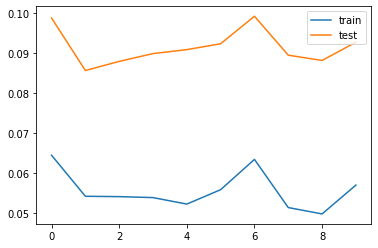

In [3]:
plt.plot(train_sum)
plt.plot(test_sum)
plt.legend(['train', 'test'], loc='upper right')

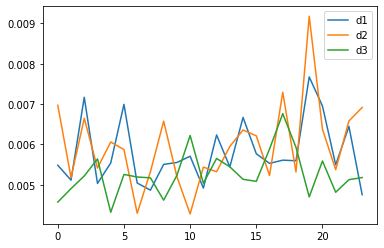

In [12]:
plt.plot(train[:, 0])
plt.plot(train[:, 1])
plt.plot(train[:, 2])
plt.legend(['d1', 'd2', 'd3'], loc='upper right')

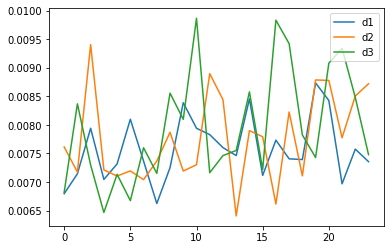

In [11]:
plt.plot(test[:, 0])
plt.plot(test[:, 1])
plt.plot(test[:, 2])
plt.legend(['d1', 'd2', 'd3'], loc='upper right')